---
### Bike sharing demand competition
- 2014.5 ~ 2015.5 / 3,424 teams applied 
- 워싱턴 DC의 자전거 무인대여 시스템 데이터 기반, 향후 자전거 대여수요 예측이 목적 
- given data: 2011 ~2012년 1시간 단위 자전거 대여기록 
  - train data: 매달 1~19일 & test data: 매달 20~말일
  - 변수: 대여 날짜, 시간, 요일, 계절, 날씨, 실제온도, 체감온도, 습도, 풍속, 회원여부 
- 평가기준 = RMSE, 제출양식 = datetime(2011-01-20 00:00:00), count(0)
- https://www.kaggle.com/competitions/bike-sharing-demand
---

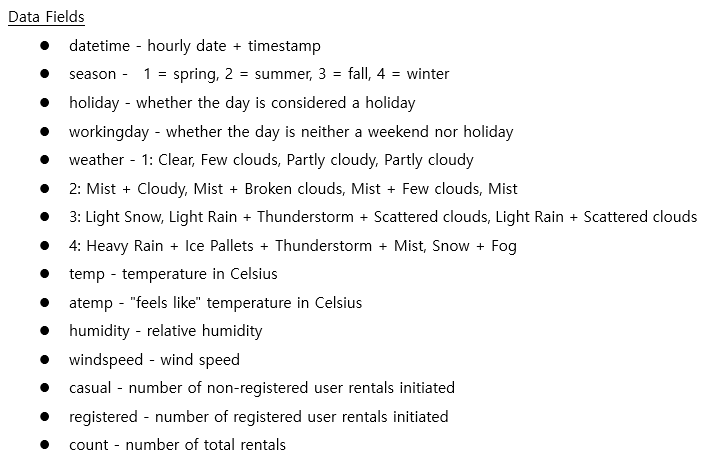

In [63]:
from IPython.display import Image
Image("images/bike_features.PNG")

In [64]:
#data import 
import numpy as np 
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt 
import seaborn as sns

data_path = 'kaggle/input/bike-sharing-demand/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

print(train.shape, test.shape, submission.shape)

(10886, 12) (6493, 9) (6493, 2)


In [65]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [66]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [67]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [68]:
#data types, N/A 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [69]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


---
- train 10886개, test 6493개. 결측치 없음 
- EDA를 위한 데이터 가공   
  - datetime(yyyy-mm-dd hh:mm:ss) --> date(yyyy-mm-dd)/연/월/일/시/분/초/요일 추출 
---

In [70]:
#2011-01-01 00:00:00 --> 우선 공백을 기준으로 2011-01-01과 00:00:00의 두 부분으로 구분 
#앞부분에서 "-"를 기준으로 구분하여 연월일 추출 
#뒷부분에서 ":"를 기준으로 구분하여 시분초 추출
train['date'] = train['datetime'].apply(lambda x: x.split()[0])
train['year'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[0]) 
train['month'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[1]) 
train['day'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[2]) 

train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0]) 
train['minute'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[1]) 
train['second'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[2]) 

#datetime과 calendar 라이브러리를 사용하여 요일 추출 
from datetime import datetime
import calendar

train['weekday'] = train['date'].apply(lambda dateString: 
                                       calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()]) 

train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday


In [71]:
#시각화를 위해 숫자로 표시된 변수들을 문자열로 변환 
train['season'] = train['season'].map({1: 'Spring', 
                                       2: 'Summer', 
                                       3: 'Fall', 
                                       4: 'Winter' 
                                       })
train['weather'] = train['weather'].map({1: 'Clear', 
                                        2: 'Mist, Few Cloud', 
                                        3: 'Light Snow, Rain, Thunderstorm', 
                                        4: 'Heavy Rain, Thunderstrom, Snow, Fog' 
                                        })

train.tail(2)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
10884,2012-12-19 22:00:00,Winter,0,1,Clear,13.94,17.425,61,6.0032,12,117,129,2012-12-19,2012,12,19,22,00,00,Wednesday
10885,2012-12-19 23:00:00,Winter,0,1,Clear,13.12,16.665,66,8.9981,4,84,88,2012-12-19,2012,12,19,23,00,00,Wednesday


---
- 시각화를 통한 EDA
---

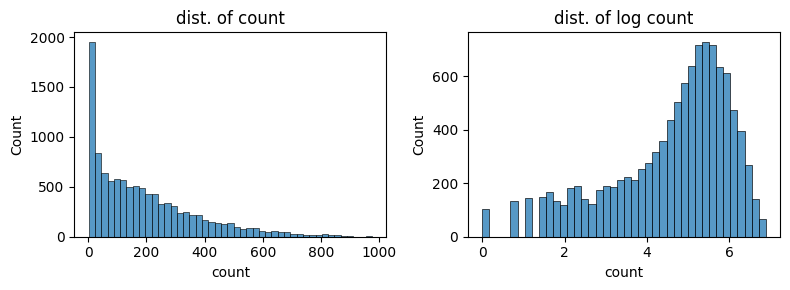

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(train['count'], ax=ax1)
sns.histplot(np.log(train['count']), ax=ax2)   #로그변환
ax1.set_title('dist. of count')
ax2.set_title('dist. of log count')
plt.tight_layout()

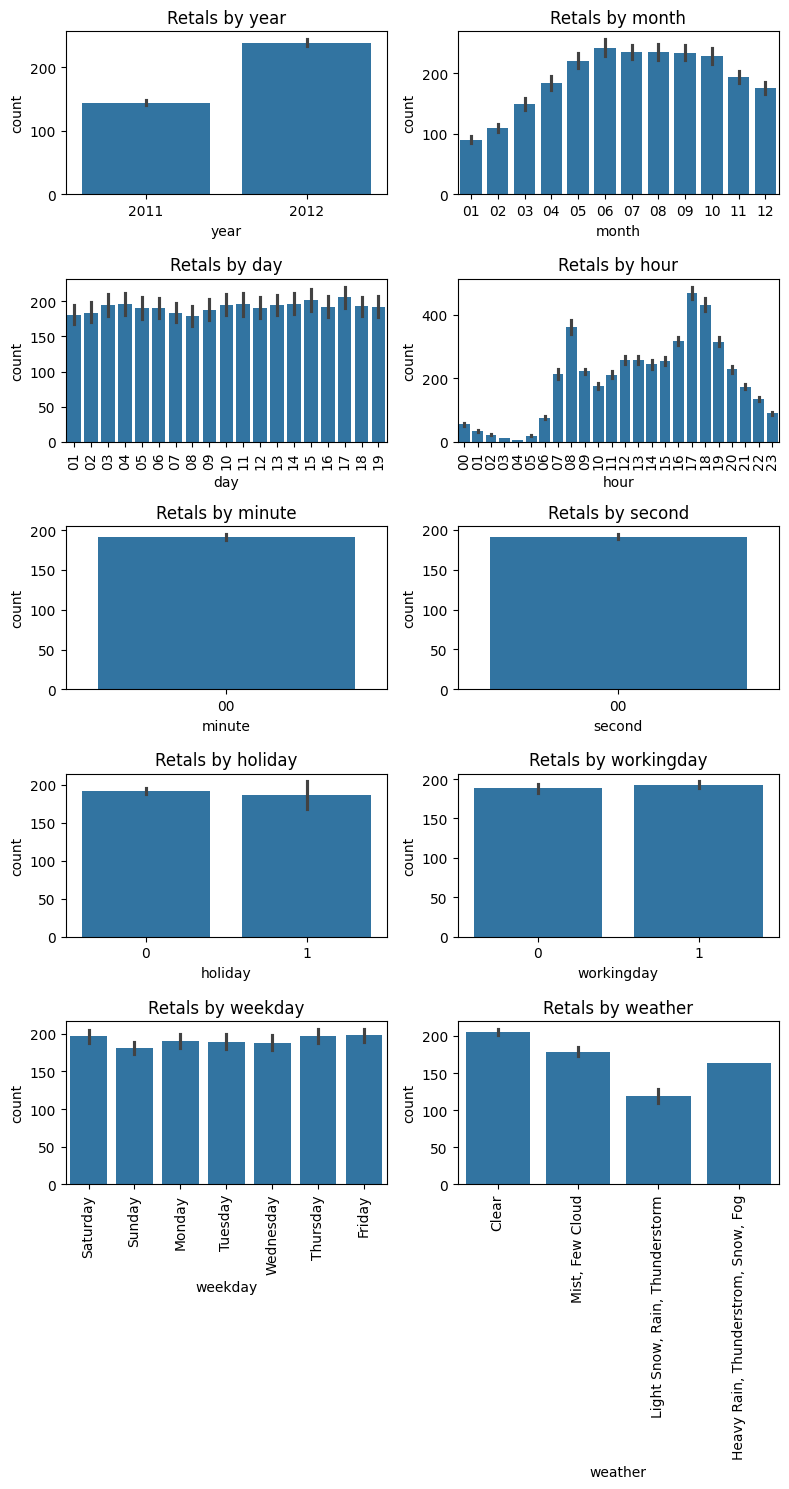

In [73]:
fig, axes = plt.subplots(5, 2, figsize=(8, 15))

sns.barplot(data=train, x='year', y='count', ax=axes[0,0])
sns.barplot(data=train, x='month', y='count', ax=axes[0,1])
sns.barplot(data=train, x='day', y='count', ax=axes[1,0])
sns.barplot(data=train, x='hour', y='count', ax=axes[1,1])
sns.barplot(data=train, x='minute', y='count', ax=axes[2,0])
sns.barplot(data=train, x='second', y='count', ax=axes[2,1])
sns.barplot(data=train, x='holiday', y='count', ax=axes[3,0])
sns.barplot(data=train, x='workingday', y='count', ax=axes[3,1])
sns.barplot(data=train, x='weekday', y='count', ax=axes[4,0])
sns.barplot(data=train, x='weather', y='count', ax=axes[4,1])

axes[0,0].set_title('Retals by year')
axes[0,1].set_title('Retals by month')
axes[1,0].set_title('Retals by day')
axes[1,1].set_title('Retals by hour')
axes[2,0].set_title('Retals by minute')
axes[2,1].set_title('Retals by second')
axes[3,0].set_title('Retals by holiday')
axes[3,1].set_title('Retals by workingday')
axes[4,0].set_title('Retals by weekday')
axes[4,1].set_title('Retals by weather')

axes[1,0].tick_params(axis='x', labelrotation=90)
axes[1,1].tick_params(axis='x', labelrotation=90)
axes[4,0].tick_params(axis='x', labelrotation=90)
axes[4,1].tick_params(axis='x', labelrotation=90)

plt.tight_layout()

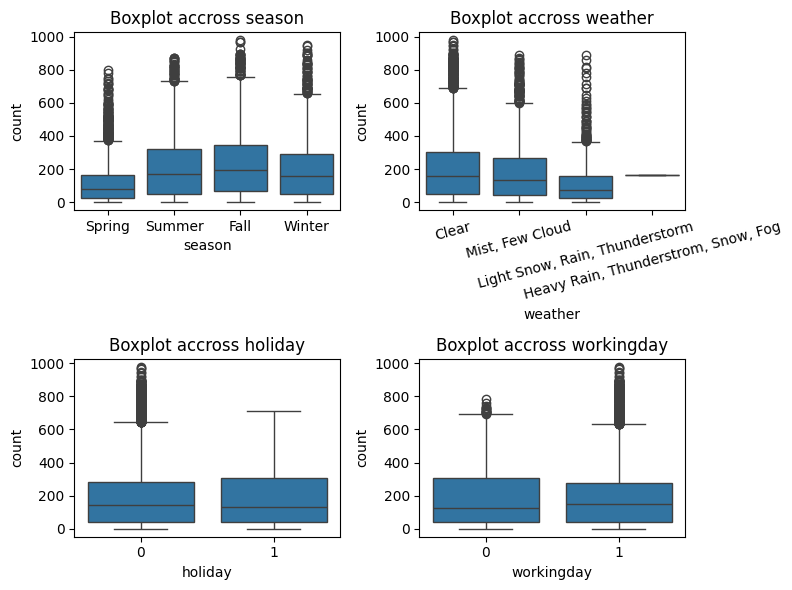

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.boxplot(data=train, x='season', y='count', ax=axes[0,0])
sns.boxplot(data=train, x='weather', y='count', ax=axes[0,1])
sns.boxplot(data=train, x='holiday', y='count', ax=axes[1,0])
sns.boxplot(data=train, x='workingday', y='count', ax=axes[1,1])

axes[0,0].set_title('Boxplot accross season')
axes[0,1].set_title('Boxplot accross weather')
axes[1,0].set_title('Boxplot accross holiday')
axes[1,1].set_title('Boxplot accross workingday')

axes[0,1].tick_params(axis='x', labelrotation=15)

plt.tight_layout()

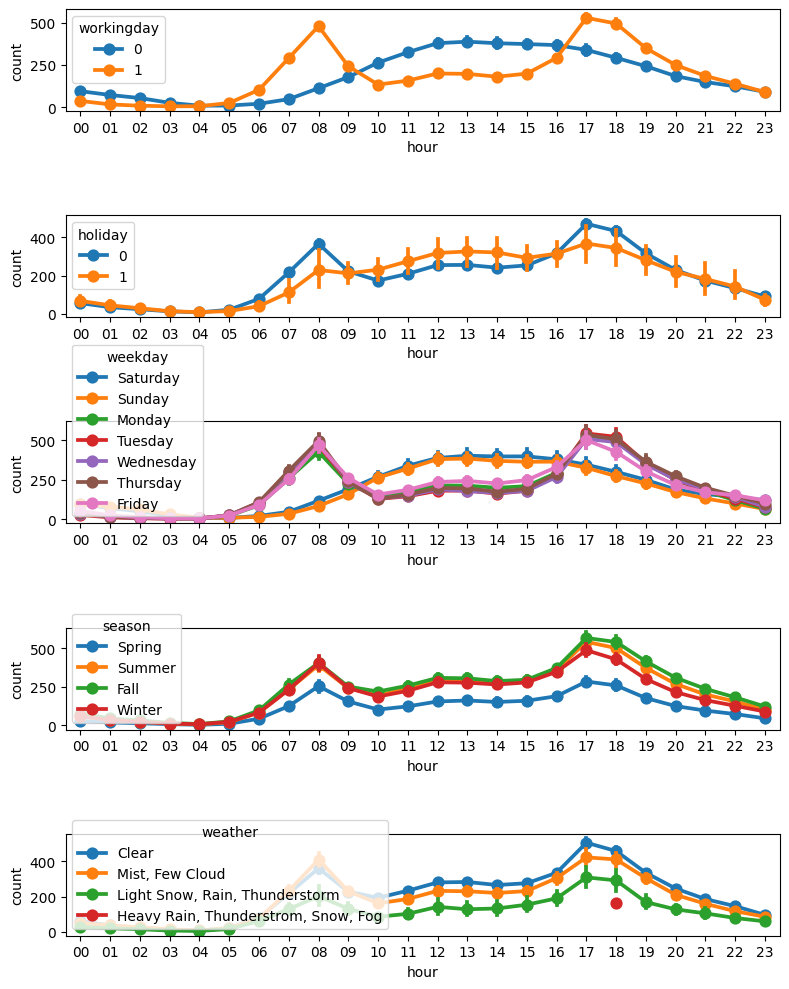

In [78]:
fig, axes = plt.subplots(5, 1, figsize=(8, 10))

sns.pointplot(data=train, x='hour', y='count', hue='workingday', ax=axes[0])
sns.pointplot(data=train, x='hour', y='count', hue='holiday', ax=axes[1])
sns.pointplot(data=train, x='hour', y='count', hue='weekday', ax=axes[2])
sns.pointplot(data=train, x='hour', y='count', hue='season', ax=axes[3])
sns.pointplot(data=train, x='hour', y='count', hue='weather', ax=axes[4])

plt.tight_layout()

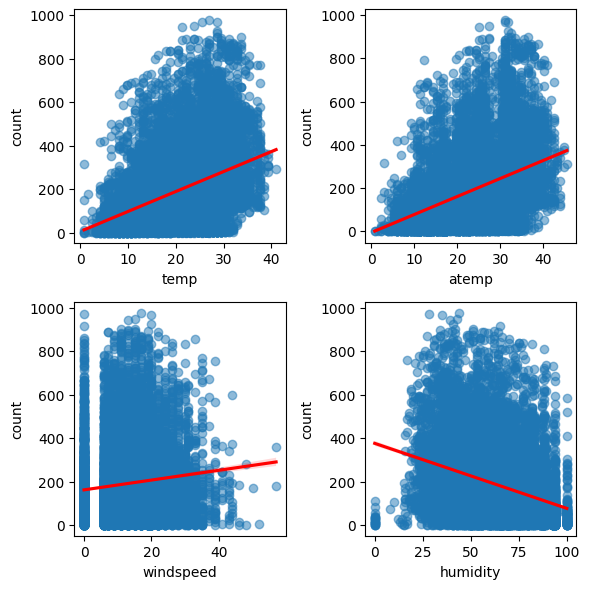

In [83]:
#온도, 체감온도, 풍속, 습도와 대여량의 관계 
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

sns.regplot(data=train, x='temp', y='count', scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=axes[0,0])
sns.regplot(data=train, x='atemp', y='count', scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=axes[0,1])
sns.regplot(data=train, x='windspeed', y='count', scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=axes[1,0])
sns.regplot(data=train, x='humidity', y='count', scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=axes[1,1])

plt.tight_layout()

               temp     atemp  humidity  windspeed     count
temp       1.000000  0.984948 -0.064949  -0.017852  0.394454
atemp      0.984948  1.000000 -0.043536  -0.057473  0.389784
humidity  -0.064949 -0.043536  1.000000  -0.318607 -0.317371
windspeed -0.017852 -0.057473 -0.318607   1.000000  0.101369
count      0.394454  0.389784 -0.317371   0.101369  1.000000


Text(0.5, 1.0, 'heatmap of features')

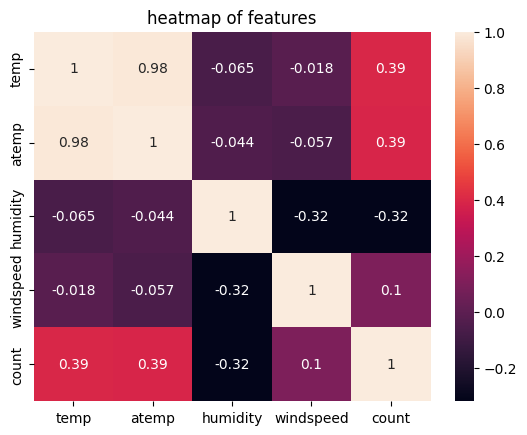

In [88]:
#수치형 변수들간의 상관관계 확인
corrmat = train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
print(corrmat)

sns.heatmap(corrmat, annot=True)
plt.title('heatmap of features')

--- 
- Findings 
  - target변수(count)가 좌편향 -> log 변환하는 것이 좋겠다. 
  - day / minute / second 변수는 의미가 없다. (분별력 없음, 정보 자체가 없음)
  - 여름과 가을에 대여수가 많고, 봄이 가장 적다. 
  - 날씨가 좋을수록 대여가 많다. 
  - 평일&근무일에 휴일 대비 outlier가 많다. 
  - 평일은 출퇴근 시간, 휴일은 낮시간에 대여가 많다. 
  - 여름/가을은 저녁 시간대에 대여가 많다. 
  - weather = 4('Heavy Rain, Thunderstrom, Snow, Fog')는 단 1개 존재한다.(이상치?)
  - 온도가 높고, 습도가 낮을 수록 대여가 많다. 
  - 풍속 = 0인 데이터가 대단히 많다. (제대로 된 데이터가 아닐수도...)
---